/home.ufs/yw4236/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home.ufs/yw4236/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


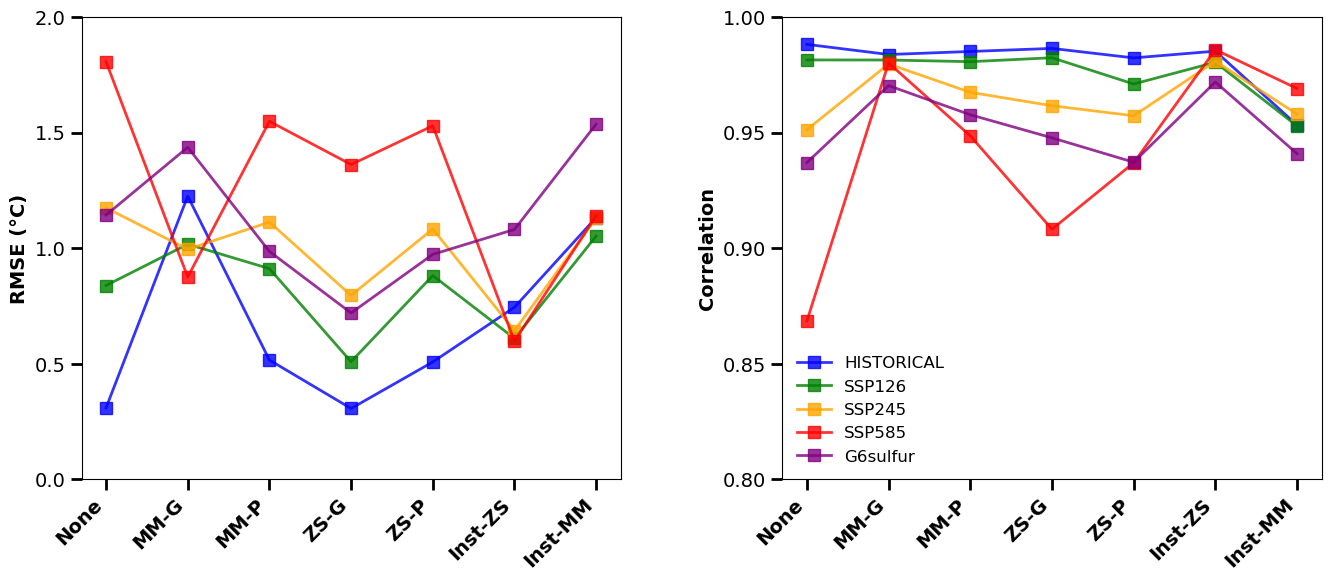

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import pearsonr

# ----------------------------
# Configuration
# ----------------------------
results_dir = Path("../evaluation_results")
figures_dir = Path("../Figures")
figures_dir.mkdir(exist_ok=True)

var = 'tas'
scenarios = ['historical', 'ssp126', 'ssp245', 'ssp585', 'g6sulfur']
normalizations = ['none', 'minmax_global', 'minmax_pixel', 'zscore_global', 
                  'zscore_pixel', 'instance_zscore', 'instance_minmax']

# Normalization labels
norm_labels = {
    'none': 'None',
    'minmax_global': 'MM-G',
    'minmax_pixel': 'MM-P',
    'zscore_global': 'ZS-G',
    'zscore_pixel': 'ZS-P',
    'instance_zscore': 'Inst-ZS',
    'instance_minmax': 'Inst-MM'
}

# Scenario colors and labels
scenario_colors = {
    'historical': 'blue',
    'ssp126': 'green',
    'ssp245': 'orange',
    'ssp585': 'red',
    'g6sulfur': 'purple'
}

scenario_labels = {
    'historical': 'HISTORICAL',
    'ssp126': 'SSP126',
    'ssp245': 'SSP245',
    'ssp585': 'SSP585',
    'g6sulfur': 'G6sulfur'
}

# ----------------------------
# Functions
# ----------------------------
def compute_spatial_mean(data):
    return data.mean(dim=['lat', 'lon']).values

def compute_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    corr, _ = pearsonr(y_true, y_pred)
    return rmse, corr

# ----------------------------
# Compute metrics for mean
# ----------------------------
metrics_mean = {scen: {} for scen in scenarios}

for scenario in scenarios:
    # Load results
    results_file = results_dir / f"tas_evaluation_{scenario}.nc"
    ds = xr.open_dataset(results_file)
    
    # Compute ground truth mean
    gt_mean = compute_spatial_mean(ds['groundtruth'])
    
    for norm in normalizations:
        pred_key = f'pred_{norm}'
        
        if pred_key not in ds:
            continue
        
        # Compute prediction mean
        pred_mean = compute_spatial_mean(ds[pred_key])
        
        # Compute metrics for mean
        rmse_mean, corr_mean = compute_metrics(gt_mean, pred_mean)
        metrics_mean[scenario][norm] = (rmse_mean, corr_mean)

# ----------------------------
# Create 1x2 visualization
# ----------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

x_positions = np.arange(len(normalizations))

# Col 0: RMSE for Mean
ax = axes[0]
for scenario in scenarios:
    y_values = [metrics_mean[scenario][norm][0] if norm in metrics_mean[scenario] else np.nan 
                for norm in normalizations]
    ax.plot(x_positions, y_values, marker='s', markersize=8, 
           label=scenario_labels[scenario], color=scenario_colors[scenario],
           linewidth=2, alpha=0.8)
ax.set_yticks([0.0, 0.5, 1.0, 1.5, 2.0])
ax.set_ylabel('RMSE (°C)', fontsize=14, fontweight='bold')
ax.set_xticks(x_positions)
ax.set_xticklabels([norm_labels[norm] for norm in normalizations], 
                    rotation=45, ha='right', fontsize=12, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=14, length=8, width=2)

# Col 1: Pearson Correlation for Mean
ax = axes[1]
for scenario in scenarios:
    y_values = [metrics_mean[scenario][norm][1] if norm in metrics_mean[scenario] else np.nan 
                for norm in normalizations]
    ax.plot(x_positions, y_values, marker='s', markersize=8, 
           label=scenario_labels[scenario], color=scenario_colors[scenario],
           linewidth=2, alpha=0.8)
ax.set_ylim((0.8, 1))
ax.set_yticks([0.80, 0.85, 0.90, 0.95, 1.0])
ax.set_ylabel('Correlation', fontsize=14, fontweight='bold')
ax.set_xticks(x_positions)
ax.set_xticklabels([norm_labels[norm] for norm in normalizations], 
                    rotation=45, ha='right', fontsize=12, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=14, length=8, width=2)
ax.legend(loc='best', fontsize=12, frameon=False)

plt.subplots_adjust(wspace=0.3)

# Save figure
output_file = figures_dir / "temporal_rmse_corr.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
